# Import Library

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# EDA (Exploratory Data Analysis)

📦 Jumlah Total Data: (768, 9)

🧾 Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

❓ Apakah Ada Missing Value?
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI    

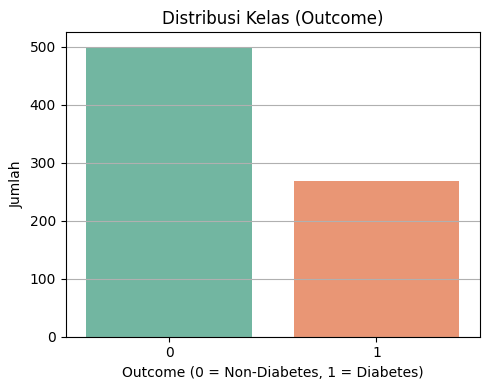

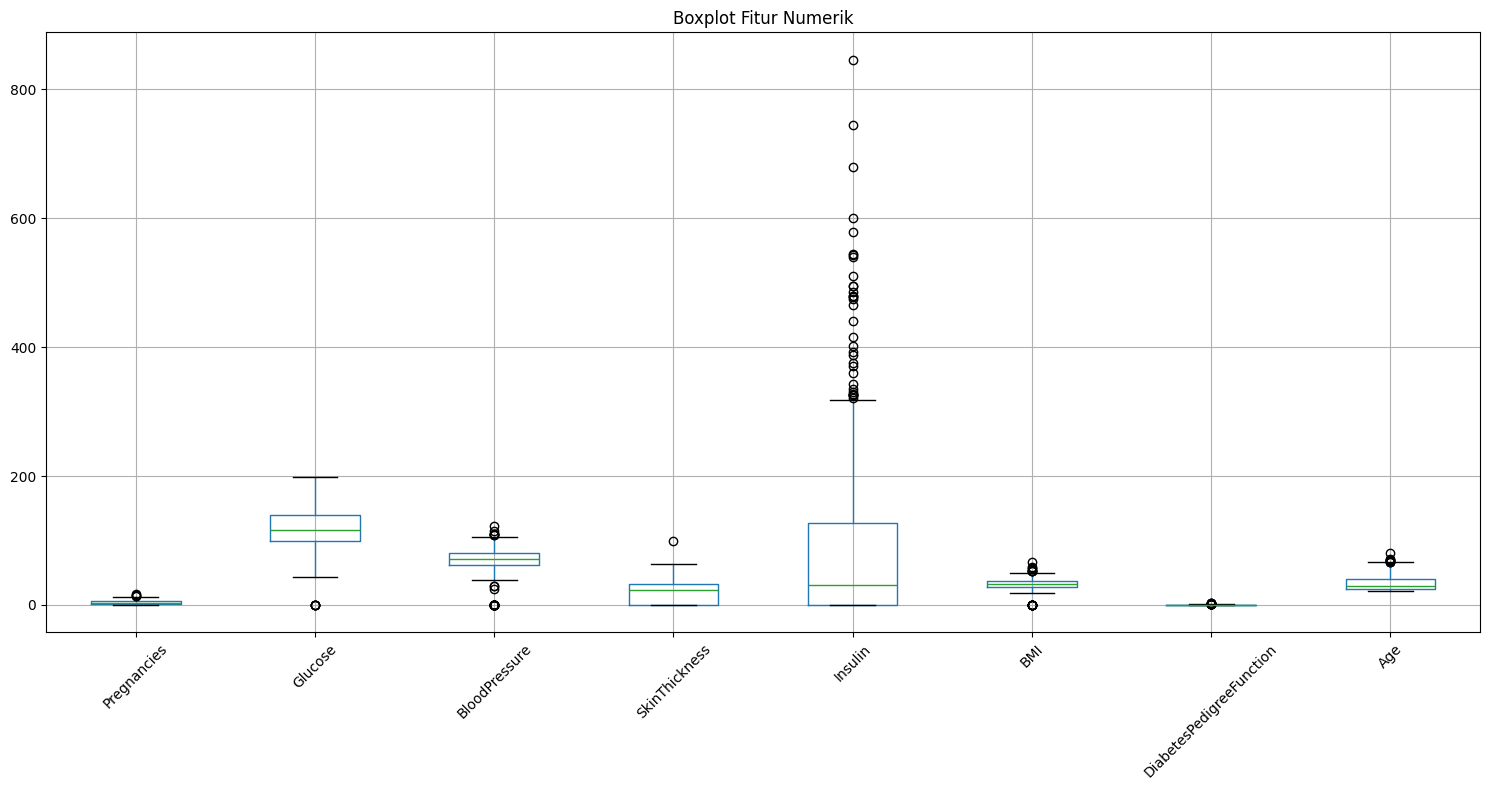

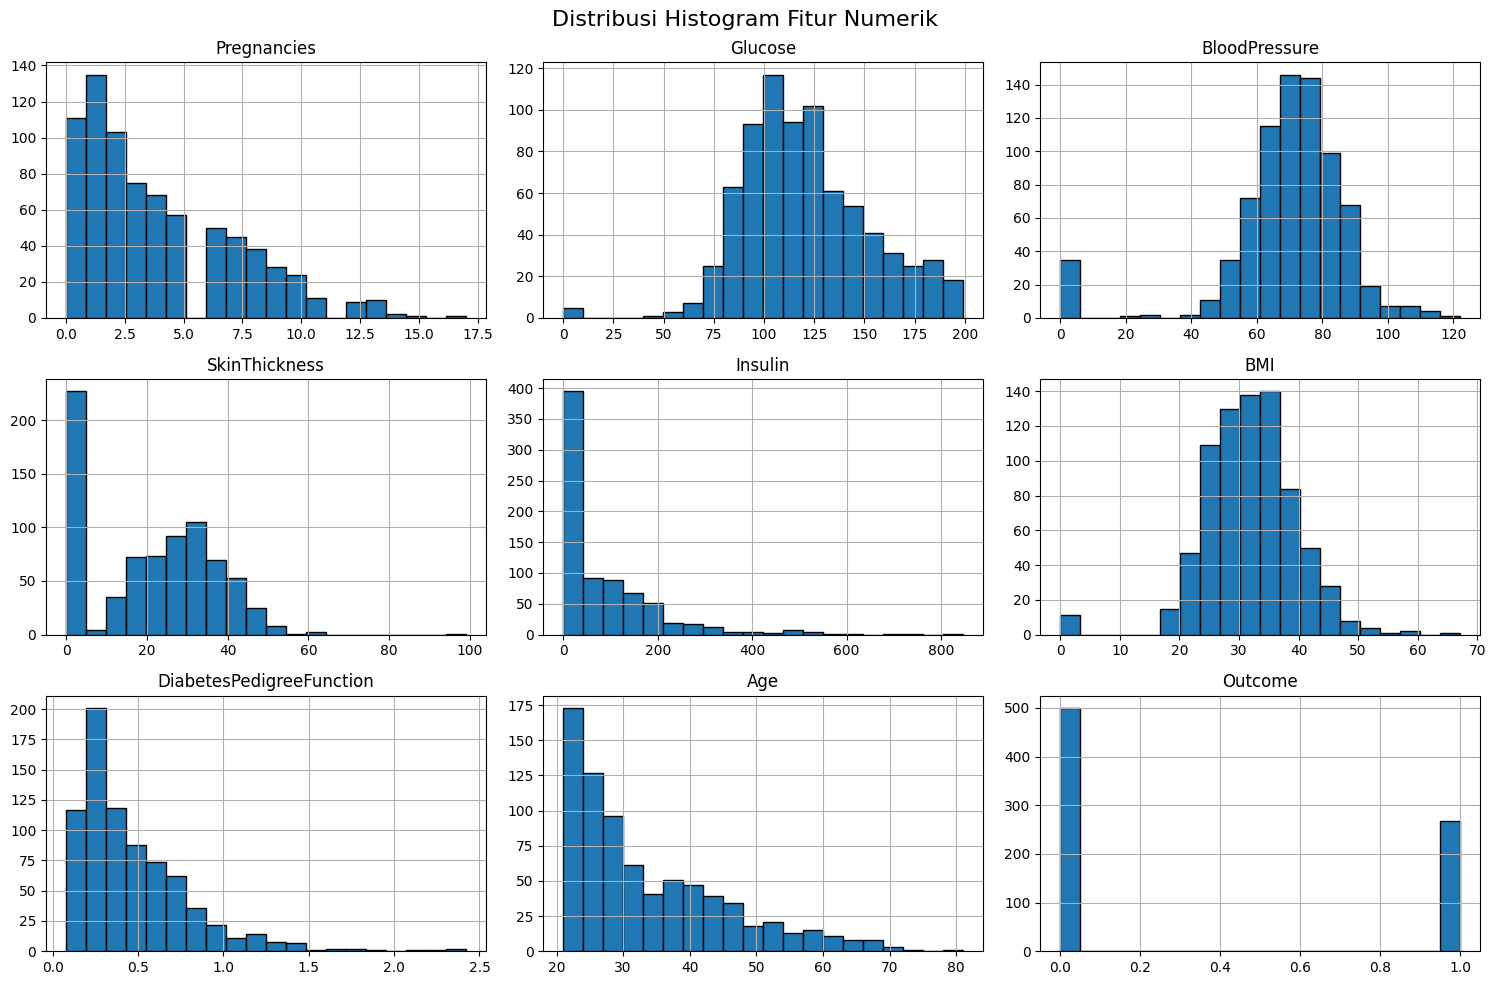

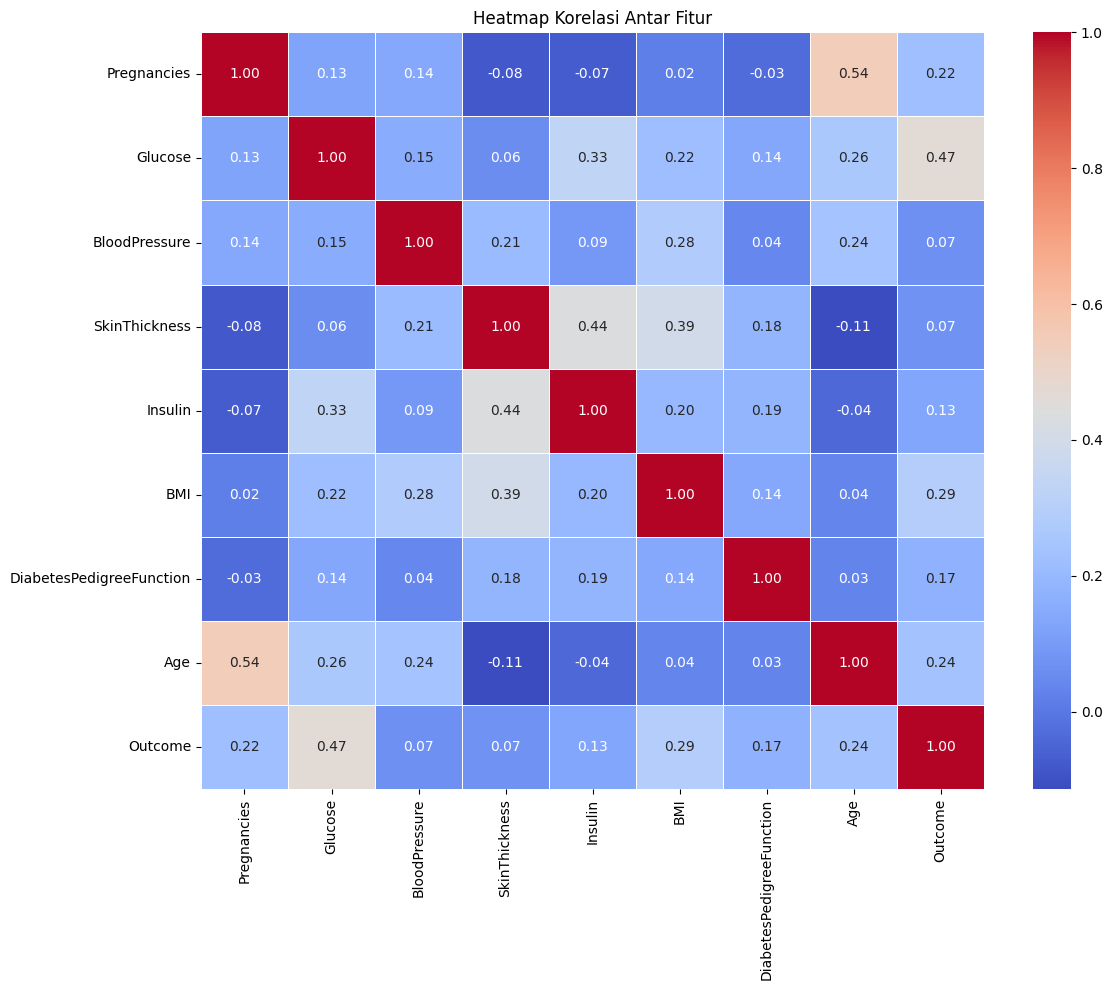

In [46]:
# Load dataset
df = pd.read_csv("Dataset/diabetes.csv")

# Info umum
print("📦 Jumlah Total Data:", df.shape)
print("\n🧾 Informasi Data:")
print(df.info())

# Cek missing value
print("\n❓ Apakah Ada Missing Value?")
print(df.isnull().sum())

# Tampilkan 5 sample data
print("\n🔍 5 Sampel Data Awal:")
print(df.head())

# Statistik deskriptif
print("\n📊 Statistik Deskriptif:")
print(df.describe())

# Distribusi kelas
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='Outcome', hue='Outcome', palette='Set2', legend=False)
plt.title("Distribusi Kelas (Outcome)")
plt.xlabel("Outcome (0 = Non-Diabetes, 1 = Diabetes)")
plt.ylabel("Jumlah")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Boxplot untuk fitur numerik sebelum feature engineering
plt.figure(figsize=(15, 8))
df.boxplot(column=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
plt.title("Boxplot Fitur Numerik")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogram distribusi fitur numerik
df.hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle("Distribusi Histogram Fitur Numerik", fontsize=16)
plt.tight_layout()
plt.show()

# Heatmap korelasi
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Fitur")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits

🌟 Best Parameters Found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}

🎯 AUC Score: 0.8217

✅ Threshold Otomatis Terbaik (berdasarkan F1-score): 0.5893

📊 Classification Report (Threshold Otomatis F1):
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        99
           1       0.68      0.71      0.70        55

    accuracy                           0.78       154
   macro avg       0.76      0.76      0.76       154
weighted avg       0.78      0.78      0.78       154



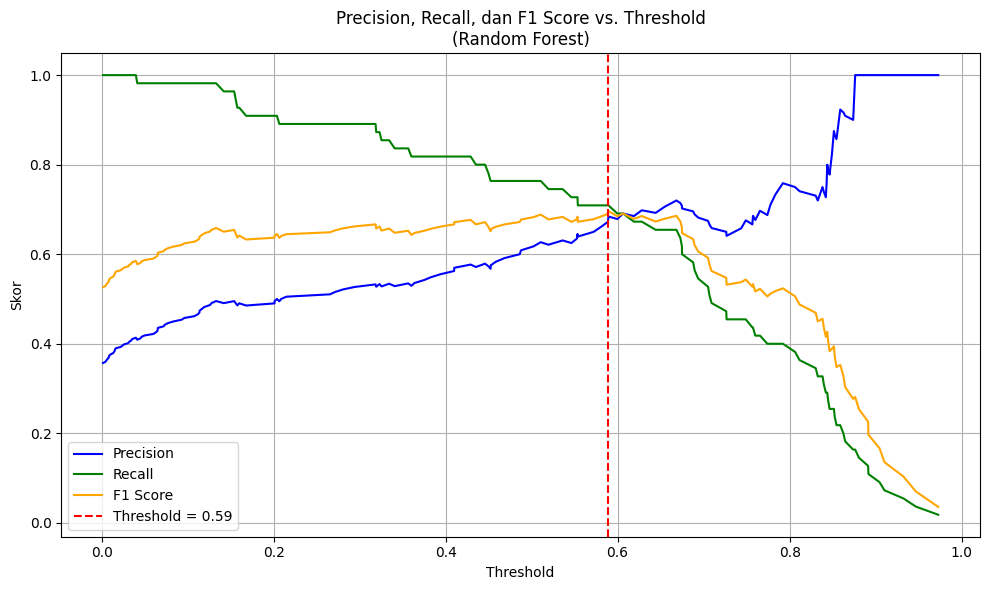

In [47]:
# Feature Engineering
df['Glucose_Insulin_Ratio'] = df['Glucose'] / (df['Insulin'] + 1)
df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Pregnancies_Age'] = df['Pregnancies'] * df['Age']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, float('inf')],
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, float('inf')],labels=['Young', 'Middle', 'Old'])

df = pd.get_dummies(df, columns=['BMI_Category', 'Age_Group'], drop_first=True)

# Feature & Label
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split + SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

from sklearn.model_selection import RandomizedSearchCV

# Definisi parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Randomized Search
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='f1', random_state=42,
                                   verbose=1, n_jobs=-1)
random_search.fit(X_resampled, y_resampled)

# Model terbaik dari hasil tuning
best_rf = random_search.best_estimator_
print("\n🌟 Best Parameters Found:", random_search.best_params_)

# Lanjut pakai model terbaik
model = best_rf
model.fit(X_resampled, y_resampled)

# Predict proba
proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)
print(f"\n🎯 AUC Score: {auc:.4f}")

# Threshold tuning (F1)
precision, recall, thresholds = precision_recall_curve(y_test, proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\n✅ Threshold Otomatis Terbaik (berdasarkan F1-score): {best_threshold:.4f}")

# Predict with best threshold
y_pred_best = (proba >= best_threshold).astype(int)

# Evaluation
print("\n📊 Classification Report (Threshold Otomatis F1):")
print(classification_report(y_test, y_pred_best))

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='orange')  
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Threshold = {best_threshold:.2f}')
plt.title("Precision, Recall, dan F1 Score vs. Threshold\n(Random Forest)")
plt.xlabel("Threshold")
plt.ylabel("Skor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Perbandingan dengan Algoritma lain

In [48]:
import pandas as pd

# Tabel evaluasi hasil akhir model
data = {
    "Metrik": ["Accuracy", "Precision (1)", "Recall (1)", "F1-Score (1)", "AUC Score", "Threshold"],
    "Logistic Regression (C=10)": [0.77, 0.65, 0.75, 0.69, 0.8220, 0.5594],
    "Random Forest (Tuned)":       [0.78, 0.68, 0.71, 0.70, 0.8217, 0.5893],
    "XGBoost (Tuned)":             [0.71, 0.57, 0.85, 0.68, 0.7666, 0.1411]
}

df = pd.DataFrame(data)

# Tampilkan tabel di terminal atau notebook
print("📊 Perbandingan Akhir Tiga Algoritma:\n")
print(df.to_string(index=False))

📊 Perbandingan Akhir Tiga Algoritma:

       Metrik  Logistic Regression (C=10)  Random Forest (Tuned)  XGBoost (Tuned)
     Accuracy                      0.7700                 0.7800           0.7100
Precision (1)                      0.6500                 0.6800           0.5700
   Recall (1)                      0.7500                 0.7100           0.8500
 F1-Score (1)                      0.6900                 0.7000           0.6800
    AUC Score                      0.8220                 0.8217           0.7666
    Threshold                      0.5594                 0.5893           0.1411


# Logistic Regression

In [49]:
# Load dataset
df = pd.read_csv("Dataset/diabetes.csv")

# Feature engineering
df['Glucose_Insulin_Ratio'] = df['Glucose'] / (df['Insulin'] + 1)
df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Pregnancies_Age'] = df['Pregnancies'] * df['Age']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, np.inf], labels=['Young', 'Middle', 'Old'])
df = pd.get_dummies(df, columns=['BMI_Category', 'Age_Group'], drop_first=True)

# Fitur lengkap (tanpa seleksi)
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split & SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Final Model (C = 10)
model = LogisticRegression(C=10, random_state=42)
model.fit(X_resampled, y_resampled)

# Predict Probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Gunakan threshold terbaik hasil tuning
best_threshold = 0.5594
y_pred = (y_proba >= best_threshold).astype(int)

# Evaluation
print(f"\n🎯 Final Model Evaluation (C=10, Threshold={best_threshold}):")
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))


🎯 Final Model Evaluation (C=10, Threshold=0.5594):
AUC Score: 0.8220

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        99
           1       0.65      0.75      0.69        55

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154



# XGboost

In [50]:
# === Feature Engineering ===
df['Glucose_Insulin_Ratio'] = df['Glucose'] / (df['Insulin'] + 1)
df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Pregnancies_Age'] = df['Pregnancies'] * df['Age']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, float('inf')],
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, float('inf')],
                         labels=['Young', 'Middle', 'Old'])

df = pd.get_dummies(df, columns=['BMI_Category', 'Age_Group'], drop_first=True)

# Features and labels
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Randomized Search
xgb = XGBClassifier(eval_metric='logloss',random_state=42)
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=20, cv=5,
    scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

# Model terbaik
best_xgb = random_search.best_estimator_
print("\n🌟 Best Parameters Found:", random_search.best_params_)

# Fit ulang model terbaik
model = best_xgb
model.fit(X_train, y_train)

# Predict probabilities
proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)
print(f"\n🎯 AUC Score: {auc:.4f}")

# Threshold tuning (based on F1)
precision, recall, thresholds = precision_recall_curve(y_test, proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\n✅ Threshold Otomatis Terbaik (berdasarkan F1-score): {best_threshold:.4f}")

# Predict with best threshold
y_pred_best = (proba >= best_threshold).astype(int)

# Evaluation
print("\n📊 Classification Report (Threshold Otomatis F1):")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 20 candidates, totalling 100 fits

🌟 Best Parameters Found: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}

🎯 AUC Score: 0.7666

✅ Threshold Otomatis Terbaik (berdasarkan F1-score): 0.1411

📊 Classification Report (Threshold Otomatis F1):
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        99
           1       0.57      0.85      0.68        55

    accuracy                           0.71       154
   macro avg       0.73      0.75      0.71       154
weighted avg       0.77      0.71      0.72       154

